<a href="https://colab.research.google.com/github/sankardevisharath/amex-default-prediction/blob/master/notebooks/Feature_Selection_Variance_Threshold_SGDClassifier_on_agg_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gc 

import numpy as np
import pandas as pd
import lightgbm as gbm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectPercentile, chi2, mutual_info_classif, RFECV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix


In [2]:
df = pd.read_parquet(path='/content/drive/MyDrive/amex-default-prediction/data/aggr/customer-agg.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458913 entries, 0 to 458912
Columns: 920 entries, customer_ID to target
dtypes: float64(891), int64(26), object(3)
memory usage: 3.1+ GB


In [4]:
columns = df.head().dtypes
columns[columns==object]


customer_ID    object
D_63_last      object
D_64_last      object
dtype: object

In [5]:
cat_cols = ['D_63', 'D_64','B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
TRAIN_LABELS_PATH = '/content/train_labels.csv'

In [6]:
X = pd.DataFrame()
Y = pd.DataFrame()

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10)
df[['D_63_last', 'D_64_last']]=enc.fit(df[['D_63_last', 'D_64_last']])
df[['D_63_last', 'D_64_last']]=enc.transform(df[['D_63_last', 'D_64_last']])
df.fillna(0, inplace=True)
X= X.append(df.loc[:, ~df.columns.isin(['customer_ID', 'target'])])
Y = Y.append(df.loc[:, df.columns == 'target'])

In [7]:
sfs = VarianceThreshold()

In [8]:
sfs = sfs.fit(X)

In [9]:
concol = [column for column in X.columns 
          if column not in X.columns[sfs.get_support()]]
len(concol)

3

In [10]:
for features in concol:
    print(features)

D_87_std
D_63_last
D_64_last


In [11]:
X.D_64_last.unique()

array([10.])

In [12]:
X = sfs.transform(X)

In [13]:
cols = sfs.get_feature_names_out()

In [14]:
X.shape

(458913, 915)

In [15]:
 X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [16]:
clf = SGDClassifier(verbose=1000)

In [17]:
%%time
clf.fit(X_train, y_train.values.ravel())

-- Epoch 1
Norm: 172.06, NNZs: 915, Bias: -47.866797, T: 367130, Avg. loss: 65.311916
Total training time: 0.65 seconds.
-- Epoch 2
Norm: 175.07, NNZs: 915, Bias: -45.925029, T: 734260, Avg. loss: 9.431806
Total training time: 1.29 seconds.
-- Epoch 3
Norm: 78.31, NNZs: 915, Bias: -44.619197, T: 1101390, Avg. loss: 6.351665
Total training time: 1.93 seconds.
-- Epoch 4
Norm: 49.82, NNZs: 915, Bias: -43.139713, T: 1468520, Avg. loss: 3.272904
Total training time: 2.57 seconds.
-- Epoch 5
Norm: 35.68, NNZs: 915, Bias: -41.913380, T: 1835650, Avg. loss: 2.097066
Total training time: 3.22 seconds.
-- Epoch 6
Norm: 48.35, NNZs: 915, Bias: -40.959496, T: 2202780, Avg. loss: 3.073378
Total training time: 3.86 seconds.
-- Epoch 7
Norm: 34.20, NNZs: 915, Bias: -40.033392, T: 2569910, Avg. loss: 1.873239
Total training time: 4.51 seconds.
-- Epoch 8
Norm: 25.86, NNZs: 915, Bias: -39.290860, T: 2937040, Avg. loss: 1.429349
Total training time: 5.16 seconds.
-- Epoch 9
Norm: 24.19, NNZs: 915, Bias

SGDClassifier(verbose=1000)

In [18]:
clf.score(X_test, y_test)

0.8808602900319231

In [19]:
clf.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 1000,
 'warm_start': False}

In [20]:
y_pred = clf.predict(X_test)

In [21]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [22]:
tn, fp, fn, tp

(60124, 8159, 2776, 20724)

In [23]:
f1_score(y_test, y_pred)

0.7912490693545616

In [24]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9559    0.8805    0.9166     68283
           1     0.7175    0.8819    0.7912     23500

    accuracy                         0.8809     91783
   macro avg     0.8367    0.8812    0.8539     91783
weighted avg     0.8948    0.8809    0.8845     91783



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


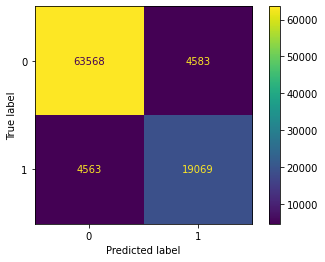

In [ ]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()



*   TN = Non defaulting customer and my model predicted that customer won't default.
*   FP = Non defaulting customer but my model predicted that the customer will default.
*   FN = Customer defaulted but my model predicted that the customer will not default.
*   TP = Customer defaulted and my model predicted customer will default.



In [ ]:
clf.feature_importances_

array([ 19,   7,  12,  23, 153,   5,  16,   0,  22,  87,   0,   3,   0,
         0,  35,  16,   0,   4,   2,  26,   8,   1,   0,   2,  23,  37,
         3,   5,   9,  36,   0,   3,   1,   2,  23,   0,  14,   0,   8,
        70,  42,   0,  21,  14,   4,  22,   5,   3,   2,  27,   2,   8,
         0,   2,  24,   4,  52,   2,   4,  72,  11,   0,   0,  18,   1,
         6,   2,   8,   8,  41,   0,   0,   0,   1,  17,  12,   0,  11,
         4,  41,  11,   0,   3,  22,  11,   2,   3,   3,   1,  17,   5,
         4,   2,   2,  56,   0,   1,   4,   0,   1,   6,   2,   0,   2,
        25,   2,   2,   3,   2,   1,   9,   2,   0,  18,  12,  10,   0,
         4,   4,   5,   5,   2,   1,   2,  12,  12,   1,   2,  12,  19,
         3,   0,   5,   2,   4,   8,   8,   2,  10,  16,   4,   5,   3,
         4,   7,   1,   3,   0,   0,   9,   2,   3,   2,   6,  18,   2,
         1,   1,   4,  42,   1,   1,   1,   0,   1,   0,   2,   3,   0,
        11,   1,   0,   0,   0,   5,   5,   2,   2,   2,   7,   

In [ ]:
clf.n_features_

915

In [ ]:
clf.booster_

In [ ]:
gbm.__version__

'2.2.3'

In [ ]:
len(clf.feature_importances_)

915

In [ ]:
feature_importance_df = pd.DataFrame(
    {'feature': cols ,
     'importance': clf.feature_importances_})

In [ ]:
feature_importance_df.sort_values(by='importance', ascending=False).head(600)

,feature,importance
4,P_2_last,153
9,D_39_last,87
59,B_4_last,72
39,B_3_last,70
94,D_49_last,56
...,...,...
799,D_130_mean,0
850,D_139_std,0
894,D_116_last,0
690,D_108_std,0
